In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import kernel_hypernet as kernel_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(kernel_hypernet)



<module 'kernel_hypernet' from '/home/leginpc/reps/VarHyperNet/code/wine/../src/kernel_hypernet.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 200 #количество эпох
lamb = [10**2, 10**3, 10**4, 10**5, 10**6]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_wine'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(100.0))/(np.log(10**6) - np.log(100.0))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.))

In [5]:
from sklearn.datasets import load_wine
from torch.utils.data import TensorDataset, DataLoader
wine_X , wine_Y = load_wine(return_X_y=True)

rs = np.random.RandomState(42)
ids = list(range(len(wine_X)))
rs.shuffle(ids)

train_X, test_X = wine_X[ids[:len(ids)*4//5]], wine_X[ids[len(ids)*4//5:]]
train_Y, test_Y = wine_Y[ids[:len(ids)*4//5]], wine_Y[ids[len(ids)*4//5:]]

mean = np.mean(train_X, 0)
std = np.std(train_X, 0)

train_X = (train_X - mean)/std
test_X = (test_X - mean)/std




train_X = t.tensor(train_X).to(device)
test_X = t.tensor(test_X).to(device)
train_Y = t.tensor(train_Y).to(device)
test_Y = t.tensor(test_Y).to(device)


train_data = TensorDataset(train_X.float(),train_Y)
train_loader = DataLoader(train_data) 

test_data = TensorDataset(test_X.float(),test_Y)
test_loader = DataLoader(test_data) 

        

In [7]:


for kernel_num in [3,5]:
    t.manual_seed(0)
    for start in range(start_num):                    
            net = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   kernel_num, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'epoch {}: '.format(e)                
                utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                      lambda_encode, net, device, loss_fn, optim, label, p_gen=lambda p_:p_*4+2)
                if e%5 == 0:
                    print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_kernel_{}_start_{}.cpk'.format(kernel_num, start)))

epoch 0: [32728.629 49661.246]: 100%|██████████| 142/142 [00:03<00:00, 39.50it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.2222222222222222, tensor(10000): 0.19444444444444445, tensor(100000): 0.0, tensor(1000000): 0.08333333333333333}


epoch 5: [23475.404 35662.31 ]: 100%|██████████| 142/142 [00:05<00:00, 26.69it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.4166666666666667, tensor(10000): 0.5, tensor(100000): 0.1388888888888889, tensor(1000000): 0.19444444444444445}


epoch 10: [24226.982 35451.246]: 100%|██████████| 142/142 [00:06<00:00, 23.02it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.4166666666666667, tensor(10000): 0.5833333333333334, tensor(100000): 0.5833333333333334, tensor(1000000): 0.2222222222222222}


epoch 15: [18979.94 28276.27]: 100%|██████████| 142/142 [00:06<00:00, 23.30it/s]  


{tensor(100): 0.4722222222222222, tensor(1000): 0.5, tensor(10000): 0.6388888888888888, tensor(100000): 0.6388888888888888, tensor(1000000): 0.2222222222222222}


epoch 20: [12321.072 18791.998]: 100%|██████████| 142/142 [00:06<00:00, 23.21it/s]  


{tensor(100): 0.5833333333333334, tensor(1000): 0.5833333333333334, tensor(10000): 0.5833333333333334, tensor(100000): 0.5555555555555556, tensor(1000000): 0.2222222222222222}


epoch 25: [ 8481.674 12948.895]: 100%|██████████| 142/142 [00:06<00:00, 22.91it/s]  


{tensor(100): 0.6388888888888888, tensor(1000): 0.6666666666666666, tensor(10000): 0.5555555555555556, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3611111111111111}


epoch 30: [5976.7993 8949.218 ]: 100%|██████████| 142/142 [00:06<00:00, 22.73it/s] 


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5555555555555556}


epoch 35: [2792.6836 4059.7793]: 100%|██████████| 142/142 [00:06<00:00, 23.04it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8055555555555556, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3611111111111111}


epoch 40: [351.97452 515.3236 ]: 100%|██████████| 142/142 [00:06<00:00, 23.15it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5}


epoch 45: [2.3053904 2.482903 ]: 100%|██████████| 142/142 [00:06<00:00, 22.93it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.4166666666666667, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6111111111111112}


epoch 50: [1.9295406 1.9900244]: 100%|██████████| 142/142 [00:06<00:00, 23.12it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.4444444444444444, tensor(100000): 0.5555555555555556, tensor(1000000): 0.4444444444444444}


epoch 55: [1.781448  1.8052406]: 100%|██████████| 142/142 [00:06<00:00, 23.10it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.4722222222222222, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5277777777777778}


epoch 60: [1.9457432 1.9644463]: 100%|██████████| 142/142 [00:06<00:00, 23.06it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.6944444444444444, tensor(1000000): 0.25}


epoch 65: [1.7794096 1.7973377]: 100%|██████████| 142/142 [00:06<00:00, 23.14it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5, tensor(100000): 0.75, tensor(1000000): 0.6388888888888888}


epoch 70: [2.1155076 2.1328766]: 100%|██████████| 142/142 [00:06<00:00, 23.20it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5833333333333334, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6111111111111112}


epoch 75: [1.9701165 1.9870944]: 100%|██████████| 142/142 [00:06<00:00, 23.05it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3611111111111111}


epoch 80: [1.913239  1.9305314]: 100%|██████████| 142/142 [00:06<00:00, 23.09it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5833333333333334}


epoch 85: [1.8873484 1.9030875]: 100%|██████████| 142/142 [00:06<00:00, 22.91it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.4444444444444444, tensor(100000): 0.5, tensor(1000000): 0.6111111111111112}


epoch 90: [2.0154307 2.0327234]: 100%|██████████| 142/142 [00:06<00:00, 23.27it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5, tensor(100000): 0.6666666666666666, tensor(1000000): 0.7777777777777778}


epoch 95: [1.8854748 1.904208 ]: 100%|██████████| 142/142 [00:06<00:00, 23.27it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.3333333333333333, tensor(100000): 0.6111111111111112, tensor(1000000): 0.4722222222222222}


epoch 100: [1.7640917 1.7808663]: 100%|██████████| 142/142 [00:06<00:00, 22.89it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.8055555555555556, tensor(1000000): 0.4166666666666667}


epoch 105: [1.819147  1.8370646]: 100%|██████████| 142/142 [00:06<00:00, 23.21it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5, tensor(100000): 0.4722222222222222, tensor(1000000): 0.6111111111111112}


epoch 110: [1.8443141 1.8603671]: 100%|██████████| 142/142 [00:06<00:00, 23.15it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.4722222222222222, tensor(1000000): 0.8611111111111112}


epoch 115: [1.8225217 1.8396156]: 100%|██████████| 142/142 [00:06<00:00, 23.02it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.3888888888888889}


epoch 120: [1.8877839 1.9041219]: 100%|██████████| 142/142 [00:06<00:00, 23.25it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.4166666666666667, tensor(100000): 0.4722222222222222, tensor(1000000): 0.6388888888888888}


epoch 125: [1.8214544 1.8391724]: 100%|██████████| 142/142 [00:05<00:00, 27.17it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5277777777777778}


epoch 130: [1.8543798 1.8732451]: 100%|██████████| 142/142 [00:04<00:00, 29.75it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.25, tensor(100000): 0.2777777777777778, tensor(1000000): 0.6666666666666666}


epoch 135: [1.9677452 1.9852086]: 100%|██████████| 142/142 [00:04<00:00, 29.81it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.6111111111111112, tensor(1000000): 0.5555555555555556}


epoch 140: [1.9018369 1.9182686]: 100%|██████████| 142/142 [00:04<00:00, 29.49it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6111111111111112}


epoch 145: [1.8360723 1.8525347]: 100%|██████████| 142/142 [00:04<00:00, 29.19it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.6944444444444444, tensor(1000000): 0.5833333333333334}


epoch 150: [1.8435538 1.8588699]: 100%|██████████| 142/142 [00:04<00:00, 29.39it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7777777777777778, tensor(100000): 0.8055555555555556, tensor(1000000): 0.1111111111111111}


epoch 155: [1.9401778 1.957312 ]: 100%|██████████| 142/142 [00:04<00:00, 29.00it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.4444444444444444}


epoch 160: [1.8250678 1.8413048]: 100%|██████████| 142/142 [00:04<00:00, 29.30it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.8055555555555556, tensor(1000000): 0.3888888888888889}


epoch 165: [1.8967062 1.912505 ]: 100%|██████████| 142/142 [00:04<00:00, 29.94it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.4722222222222222, tensor(1000000): 0.6111111111111112}


epoch 170: [1.9321944 1.9516791]: 100%|██████████| 142/142 [00:04<00:00, 29.80it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.5277777777777778, tensor(1000000): 0.3055555555555556}


epoch 175: [1.9248917 1.9407421]: 100%|██████████| 142/142 [00:04<00:00, 29.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6388888888888888, tensor(100000): 0.6388888888888888, tensor(1000000): 0.6111111111111112}


epoch 180: [1.8598206 1.8761289]: 100%|██████████| 142/142 [00:04<00:00, 29.33it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6666666666666666, tensor(1000000): 0.75}


epoch 185: [1.8952178 1.9124818]: 100%|██████████| 142/142 [00:04<00:00, 29.53it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.8055555555555556, tensor(1000000): 0.3055555555555556}


epoch 190: [1.8910607 1.9074609]: 100%|██████████| 142/142 [00:04<00:00, 29.50it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.6111111111111112}


epoch 195: [1.9266831 1.9434481]: 100%|██████████| 142/142 [00:04<00:00, 29.22it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.6111111111111112, tensor(1000000): 0.5}


epoch 0: [32134.402 47807.125]: 100%|██████████| 142/142 [00:04<00:00, 29.51it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.3611111111111111, tensor(10000): 0.3333333333333333, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3333333333333333}


epoch 5: [22569.633 35754.72 ]: 100%|██████████| 142/142 [00:04<00:00, 29.51it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.3611111111111111, tensor(10000): 0.3888888888888889, tensor(100000): 0.3333333333333333, tensor(1000000): 0.2222222222222222}


epoch 10: [26551.7   38955.266]: 100%|██████████| 142/142 [00:04<00:00, 29.16it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3611111111111111, tensor(10000): 0.3333333333333333, tensor(100000): 0.3333333333333333, tensor(1000000): 0.16666666666666666}


epoch 15: [16993.973 26117.295]: 100%|██████████| 142/142 [00:04<00:00, 30.15it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.4444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.25, tensor(1000000): 0.1111111111111111}


epoch 20: [16099.997 24073.957]: 100%|██████████| 142/142 [00:04<00:00, 29.91it/s]  


{tensor(100): 0.5555555555555556, tensor(1000): 0.6666666666666666, tensor(10000): 0.2777777777777778, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3055555555555556}


epoch 25: [ 9697.83  14625.353]: 100%|██████████| 142/142 [00:04<00:00, 29.58it/s]  


{tensor(100): 0.7777777777777778, tensor(1000): 0.8888888888888888, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 30: [6169.352 9227.069]: 100%|██████████| 142/142 [00:04<00:00, 29.73it/s]    


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.4722222222222222}


epoch 35: [2555.0698 3853.0383]: 100%|██████████| 142/142 [00:04<00:00, 30.01it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.6944444444444444, tensor(1000000): 0.4444444444444444}


epoch 40: [354.54587 525.95386]: 100%|██████████| 142/142 [00:04<00:00, 29.57it/s]


{tensor(100): 1.0, tensor(1000): 1.0, tensor(10000): 0.8611111111111112, tensor(100000): 0.9166666666666666, tensor(1000000): 0.3611111111111111}


epoch 45: [2.2608445 2.4415874]: 100%|██████████| 142/142 [00:04<00:00, 29.39it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.7222222222222222, tensor(100000): 0.75, tensor(1000000): 0.6666666666666666}


epoch 50: [1.896423  1.9614044]: 100%|██████████| 142/142 [00:04<00:00, 29.37it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7222222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.8333333333333334}


epoch 55: [1.8895515 1.9134424]: 100%|██████████| 142/142 [00:04<00:00, 29.31it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6388888888888888, tensor(100000): 0.75, tensor(1000000): 0.6111111111111112}


epoch 60: [1.9648944 1.9822443]: 100%|██████████| 142/142 [00:04<00:00, 29.10it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5555555555555556}


epoch 65: [1.8861318 1.9021701]: 100%|██████████| 142/142 [00:04<00:00, 29.19it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.75, tensor(1000000): 0.4444444444444444}


epoch 70: [1.9190398 1.935796 ]: 100%|██████████| 142/142 [00:04<00:00, 29.01it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6111111111111112}


epoch 75: [1.9605134 1.977429 ]: 100%|██████████| 142/142 [00:04<00:00, 29.18it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5555555555555556, tensor(100000): 0.6944444444444444, tensor(1000000): 0.6944444444444444}


epoch 80: [2.0083792 2.0273106]: 100%|██████████| 142/142 [00:04<00:00, 29.73it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5277777777777778, tensor(1000000): 0.5833333333333334}


epoch 85: [1.88571   1.9026074]: 100%|██████████| 142/142 [00:04<00:00, 29.35it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.6388888888888888}


epoch 90: [1.7736975 1.7895423]: 100%|██████████| 142/142 [00:04<00:00, 29.39it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.6944444444444444, tensor(1000000): 0.5555555555555556}


epoch 95: [2.0027215 2.020526 ]: 100%|██████████| 142/142 [00:04<00:00, 29.94it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.5277777777777778, tensor(100000): 0.7777777777777778, tensor(1000000): 0.6111111111111112}


epoch 100: [1.7933147 1.8114222]: 100%|██████████| 142/142 [00:04<00:00, 30.00it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.7777777777777778, tensor(1000000): 0.4166666666666667}


epoch 105: [1.975467  1.9950866]: 100%|██████████| 142/142 [00:04<00:00, 29.58it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.6944444444444444, tensor(100000): 0.7777777777777778, tensor(1000000): 0.7222222222222222}


epoch 110: [1.8352528 1.85331  ]: 100%|██████████| 142/142 [00:04<00:00, 29.44it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5, tensor(100000): 0.5555555555555556, tensor(1000000): 0.4166666666666667}


epoch 115: [1.9319025 1.9486057]: 100%|██████████| 142/142 [00:04<00:00, 29.63it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7777777777777778, tensor(100000): 0.75, tensor(1000000): 0.4722222222222222}


epoch 120: [1.8144567 1.8323084]: 100%|██████████| 142/142 [00:04<00:00, 28.78it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6944444444444444, tensor(100000): 0.7777777777777778, tensor(1000000): 0.8055555555555556}


epoch 125: [2.1810923 2.1991403]: 100%|██████████| 142/142 [00:04<00:00, 29.81it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5277777777777778, tensor(1000000): 0.7777777777777778}


epoch 130: [1.9251055 1.9427378]: 100%|██████████| 142/142 [00:04<00:00, 29.50it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.4444444444444444}


epoch 135: [1.9138467 1.9322077]: 100%|██████████| 142/142 [00:04<00:00, 29.80it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.6666666666666666}


epoch 140: [1.8936632 1.9105166]: 100%|██████████| 142/142 [00:04<00:00, 29.16it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.6944444444444444, tensor(1000000): 0.3888888888888889}


epoch 145: [1.86417   1.8809465]: 100%|██████████| 142/142 [00:04<00:00, 29.59it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5833333333333334}


epoch 150: [2.0765045 2.0929449]: 100%|██████████| 142/142 [00:04<00:00, 30.00it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.19444444444444445}


epoch 155: [1.924697  1.9420581]: 100%|██████████| 142/142 [00:04<00:00, 28.79it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6111111111111112}


epoch 160: [1.9700325 1.9888915]: 100%|██████████| 142/142 [00:04<00:00, 29.60it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.4722222222222222}


epoch 165: [1.8240823 1.842623 ]: 100%|██████████| 142/142 [00:04<00:00, 29.32it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.19444444444444445, tensor(100000): 0.19444444444444445, tensor(1000000): 0.5555555555555556}


epoch 170: [1.6812861 1.6980621]: 100%|██████████| 142/142 [00:04<00:00, 29.41it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5, tensor(100000): 0.5277777777777778, tensor(1000000): 0.7777777777777778}


epoch 175: [1.8110495 1.8280765]: 100%|██████████| 142/142 [00:04<00:00, 29.44it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.6111111111111112, tensor(1000000): 0.4166666666666667}


epoch 180: [1.9405506 1.9585727]: 100%|██████████| 142/142 [00:04<00:00, 29.43it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.4444444444444444, tensor(1000000): 0.4722222222222222}


epoch 185: [1.9896598 2.0102925]: 100%|██████████| 142/142 [00:04<00:00, 29.68it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.4722222222222222, tensor(100000): 0.4722222222222222, tensor(1000000): 0.4444444444444444}


epoch 190: [1.9746957 1.9900621]: 100%|██████████| 142/142 [00:04<00:00, 29.17it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.7222222222222222, tensor(1000000): 0.75}


epoch 195: [1.9650939 1.9832658]: 100%|██████████| 142/142 [00:04<00:00, 29.74it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.3611111111111111}


epoch 0: [37634.562 55389.195]: 100%|██████████| 142/142 [00:04<00:00, 29.61it/s]


{tensor(100): 0.2222222222222222, tensor(1000): 0.25, tensor(10000): 0.2777777777777778, tensor(100000): 0.3611111111111111, tensor(1000000): 0.4444444444444444}


epoch 5: [30125.377 44269.215]: 100%|██████████| 142/142 [00:04<00:00, 29.02it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.4444444444444444, tensor(10000): 0.3333333333333333, tensor(100000): 0.25, tensor(1000000): 0.3888888888888889}


epoch 10: [19878.25  30310.955]: 100%|██████████| 142/142 [00:04<00:00, 29.57it/s]


{tensor(100): 0.6111111111111112, tensor(1000): 0.6388888888888888, tensor(10000): 0.2222222222222222, tensor(100000): 0.19444444444444445, tensor(1000000): 0.4166666666666667}


epoch 15: [16201.213 24711.219]: 100%|██████████| 142/142 [00:04<00:00, 29.83it/s] 


{tensor(100): 0.6944444444444444, tensor(1000): 0.8055555555555556, tensor(10000): 0.2222222222222222, tensor(100000): 0.19444444444444445, tensor(1000000): 0.4444444444444444}


epoch 20: [13399.296 20480.178]: 100%|██████████| 142/142 [00:04<00:00, 29.46it/s]  


{tensor(100): 0.75, tensor(1000): 0.8888888888888888, tensor(10000): 0.25, tensor(100000): 0.25, tensor(1000000): 0.5}


epoch 25: [10216.026 15170.602]: 100%|██████████| 142/142 [00:04<00:00, 29.99it/s]  


{tensor(100): 0.7222222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.3611111111111111, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5}


epoch 30: [6810.825 9875.837]: 100%|██████████| 142/142 [00:04<00:00, 29.72it/s]    


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.5}


epoch 35: [2279.8135 3475.9763]: 100%|██████████| 142/142 [00:04<00:00, 29.35it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.8055555555555556, tensor(1000000): 0.8611111111111112}


epoch 40: [290.12665 441.70374]: 100%|██████████| 142/142 [00:04<00:00, 29.57it/s]


{tensor(100): 1.0, tensor(1000): 1.0, tensor(10000): 0.8055555555555556, tensor(100000): 0.7777777777777778, tensor(1000000): 0.4444444444444444}


epoch 45: [2.4413192 2.6270971]: 100%|██████████| 142/142 [00:04<00:00, 29.53it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.6944444444444444, tensor(100000): 0.6944444444444444, tensor(1000000): 0.3333333333333333}


epoch 50: [1.9964883 2.0633407]: 100%|██████████| 142/142 [00:04<00:00, 29.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6111111111111112, tensor(100000): 0.7777777777777778, tensor(1000000): 0.2777777777777778}


epoch 55: [1.7807153 1.8066423]: 100%|██████████| 142/142 [00:04<00:00, 29.30it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6388888888888888, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6388888888888888}


epoch 60: [2.001377  2.0181496]: 100%|██████████| 142/142 [00:04<00:00, 29.50it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8333333333333334, tensor(1000000): 0.4722222222222222}


epoch 65: [1.7611831 1.7781454]: 100%|██████████| 142/142 [00:04<00:00, 29.77it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.7222222222222222, tensor(1000000): 0.5555555555555556}


epoch 70: [1.8713901 1.8870538]: 100%|██████████| 142/142 [00:04<00:00, 29.64it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6111111111111112}


epoch 75: [2.0125353 2.0279016]: 100%|██████████| 142/142 [00:04<00:00, 29.85it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6944444444444444}


epoch 80: [1.7586312 1.7739247]: 100%|██████████| 142/142 [00:04<00:00, 29.39it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.4444444444444444}


epoch 85: [1.9698455 1.9862913]: 100%|██████████| 142/142 [00:04<00:00, 29.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.6111111111111112}


epoch 90: [1.9363142 1.9547188]: 100%|██████████| 142/142 [00:04<00:00, 29.66it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.6944444444444444}


epoch 95: [2.053956  2.0715694]: 100%|██████████| 142/142 [00:04<00:00, 29.20it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.6944444444444444, tensor(1000000): 0.5277777777777778}


epoch 100: [1.9748375 1.9928697]: 100%|██████████| 142/142 [00:04<00:00, 29.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5833333333333334}


epoch 105: [2.0110488 2.027363 ]: 100%|██████████| 142/142 [00:04<00:00, 29.16it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.7222222222222222, tensor(1000000): 0.4722222222222222}


epoch 110: [1.955856  1.9724835]: 100%|██████████| 142/142 [00:04<00:00, 29.15it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.6388888888888888, tensor(1000000): 0.6388888888888888}


epoch 115: [1.8441839 1.8600787]: 100%|██████████| 142/142 [00:04<00:00, 29.46it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.7222222222222222, tensor(1000000): 0.19444444444444445}


epoch 120: [1.9782194 1.9950619]: 100%|██████████| 142/142 [00:04<00:00, 29.68it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.75, tensor(1000000): 0.7777777777777778}


epoch 125: [2.0032542 2.0211525]: 100%|██████████| 142/142 [00:04<00:00, 30.03it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5277777777777778}


epoch 130: [2.059358  2.0768707]: 100%|██████████| 142/142 [00:04<00:00, 29.68it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.8611111111111112, tensor(1000000): 0.3888888888888889}


epoch 135: [1.841968  1.8595514]: 100%|██████████| 142/142 [00:04<00:00, 29.67it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6111111111111112, tensor(100000): 0.7222222222222222, tensor(1000000): 0.8333333333333334}


epoch 140: [1.7975132 1.8147153]: 100%|██████████| 142/142 [00:04<00:00, 29.61it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6944444444444444}


epoch 145: [2.0551767 2.0741396]: 100%|██████████| 142/142 [00:04<00:00, 29.50it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8611111111111112, tensor(1000000): 0.8611111111111112}


epoch 150: [1.9378301 1.9554042]: 100%|██████████| 142/142 [00:04<00:00, 29.78it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5}


epoch 155: [1.864264  1.8805244]: 100%|██████████| 142/142 [00:04<00:00, 30.06it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6944444444444444, tensor(100000): 0.6666666666666666, tensor(1000000): 0.6111111111111112}


epoch 160: [1.8746829 1.8919001]: 100%|██████████| 142/142 [00:04<00:00, 29.44it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5833333333333334}


epoch 165: [1.7576699 1.7729161]: 100%|██████████| 142/142 [00:04<00:00, 29.67it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.75, tensor(100000): 0.6944444444444444, tensor(1000000): 0.5277777777777778}


epoch 170: [1.8935379 1.9105885]: 100%|██████████| 142/142 [00:04<00:00, 29.52it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6388888888888888}


epoch 175: [1.9034078 1.9195725]: 100%|██████████| 142/142 [00:04<00:00, 29.32it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5277777777777778}


epoch 180: [1.8796798 1.8984747]: 100%|██████████| 142/142 [00:04<00:00, 29.66it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.16666666666666666}


epoch 185: [1.877296  1.8945864]: 100%|██████████| 142/142 [00:04<00:00, 29.28it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3611111111111111}


epoch 190: [2.0220928 2.039675 ]: 100%|██████████| 142/142 [00:04<00:00, 29.11it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.25, tensor(100000): 0.5555555555555556, tensor(1000000): 0.6666666666666666}


epoch 195: [1.9190999 1.9372385]: 100%|██████████| 142/142 [00:04<00:00, 30.18it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6388888888888888, tensor(100000): 0.6666666666666666, tensor(1000000): 0.5277777777777778}


epoch 0: [32951.58  49907.594]: 100%|██████████| 142/142 [00:04<00:00, 29.69it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3333333333333333, tensor(10000): 0.3611111111111111, tensor(100000): 0.2222222222222222, tensor(1000000): 0.2777777777777778}


epoch 5: [25984.09  38891.895]: 100%|██████████| 142/142 [00:04<00:00, 29.48it/s]


{tensor(100): 0.5555555555555556, tensor(1000): 0.4722222222222222, tensor(10000): 0.3333333333333333, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3611111111111111}


epoch 10: [19729.26 31281.17]: 100%|██████████| 142/142 [00:04<00:00, 29.66it/s]  


{tensor(100): 0.7222222222222222, tensor(1000): 0.8333333333333334, tensor(10000): 0.2777777777777778, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3888888888888889}


epoch 15: [16111.652 24477.053]: 100%|██████████| 142/142 [00:04<00:00, 28.93it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.7777777777777778, tensor(10000): 0.25, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 20: [13267.984 19825.22 ]: 100%|██████████| 142/142 [00:04<00:00, 29.95it/s] 


{tensor(100): 0.9166666666666666, tensor(1000): 0.8055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 25: [ 9630.77  14534.325]: 100%|██████████| 142/142 [00:04<00:00, 29.83it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 30: [5819.056 8920.216]: 100%|██████████| 142/142 [00:04<00:00, 29.15it/s]    


{tensor(100): 0.8055555555555556, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 35: [2720.3745 4077.9019]: 100%|██████████| 142/142 [00:04<00:00, 29.67it/s]


{tensor(100): 0.7777777777777778, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [313.35483 483.2873 ]: 100%|██████████| 142/142 [00:04<00:00, 29.32it/s]


{tensor(100): 0.7777777777777778, tensor(1000): 1.0, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.5555555555555556}


epoch 45: [18.186356 26.995789]: 100%|██████████| 142/142 [00:04<00:00, 29.56it/s] 


{tensor(100): 0.75, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3611111111111111}


epoch 50: [14.805804 21.088814]: 100%|██████████| 142/142 [00:04<00:00, 29.39it/s]


{tensor(100): 0.7777777777777778, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.25}


epoch 55: [12.000451 16.754135]: 100%|██████████| 142/142 [00:04<00:00, 29.88it/s]  


{tensor(100): 0.7777777777777778, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 60: [ 8.863803 12.723499]: 100%|██████████| 142/142 [00:03<00:00, 44.46it/s]  


{tensor(100): 0.7777777777777778, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.19444444444444445}


epoch 65: [6.236692 8.306632]: 100%|██████████| 142/142 [00:03<00:00, 43.11it/s]   


{tensor(100): 0.8055555555555556, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.4722222222222222}


epoch 70: [4.236882 5.437022]: 100%|██████████| 142/142 [00:03<00:00, 43.92it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3611111111111111}


epoch 75: [2.618139 3.013829]: 100%|██████████| 142/142 [00:03<00:00, 44.35it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.5277777777777778}


epoch 80: [2.091523  2.1513515]: 100%|██████████| 142/142 [00:03<00:00, 44.02it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 85: [1.8384566 1.8597666]: 100%|██████████| 142/142 [00:03<00:00, 44.44it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.4722222222222222}


epoch 90: [1.9232407 1.9420776]: 100%|██████████| 142/142 [00:03<00:00, 43.83it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.5555555555555556, tensor(100000): 0.5555555555555556, tensor(1000000): 0.5277777777777778}


epoch 95: [1.8172196 1.8340665]: 100%|██████████| 142/142 [00:03<00:00, 43.72it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8055555555555556, tensor(1000000): 0.4444444444444444}


epoch 100: [1.9856381 2.00354  ]: 100%|██████████| 142/142 [00:03<00:00, 44.58it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5277777777777778, tensor(1000000): 0.5555555555555556}


epoch 105: [1.884651  1.9007859]: 100%|██████████| 142/142 [00:03<00:00, 43.18it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.5555555555555556, tensor(1000000): 0.19444444444444445}


epoch 110: [2.0833747 2.102523 ]: 100%|██████████| 142/142 [00:03<00:00, 43.66it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.75, tensor(1000000): 0.6111111111111112}


epoch 115: [2.0133927 2.0306609]: 100%|██████████| 142/142 [00:03<00:00, 43.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3611111111111111}


epoch 120: [1.9735569 1.9907098]: 100%|██████████| 142/142 [00:03<00:00, 44.34it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.75, tensor(1000000): 0.3611111111111111}


epoch 125: [1.9013449 1.9184498]: 100%|██████████| 142/142 [00:03<00:00, 44.10it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6666666666666666, tensor(1000000): 0.6111111111111112}


epoch 130: [1.9450862 1.9610549]: 100%|██████████| 142/142 [00:03<00:00, 44.13it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3611111111111111}


epoch 135: [1.9576719 1.9747392]: 100%|██████████| 142/142 [00:03<00:00, 43.68it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5555555555555556, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3888888888888889}


epoch 140: [1.8745013 1.8915123]: 100%|██████████| 142/142 [00:03<00:00, 42.21it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.75, tensor(1000000): 0.16666666666666666}


epoch 145: [1.9667592 1.9831289]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.3333333333333333}


epoch 150: [1.9526329 1.9697638]: 100%|██████████| 142/142 [00:03<00:00, 42.78it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6111111111111112}


epoch 155: [1.9191728 1.9361821]: 100%|██████████| 142/142 [00:03<00:00, 43.63it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.4722222222222222, tensor(1000000): 0.8333333333333334}


epoch 160: [1.9630723 1.980996 ]: 100%|██████████| 142/142 [00:03<00:00, 43.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.7777777777777778, tensor(1000000): 0.3611111111111111}


epoch 165: [1.8549967 1.8722126]: 100%|██████████| 142/142 [00:03<00:00, 43.49it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.7777777777777778, tensor(1000000): 0.1388888888888889}


epoch 170: [1.8464875 1.8631425]: 100%|██████████| 142/142 [00:03<00:00, 44.65it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.4166666666666667, tensor(100000): 0.4166666666666667, tensor(1000000): 0.2777777777777778}


epoch 175: [1.9934416 2.0104148]: 100%|██████████| 142/142 [00:03<00:00, 44.10it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.75, tensor(1000000): 0.3888888888888889}


epoch 180: [1.9636351 1.9786035]: 100%|██████████| 142/142 [00:03<00:00, 43.74it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5555555555555556}


epoch 185: [2.0090146 2.0245595]: 100%|██████████| 142/142 [00:03<00:00, 44.52it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.8333333333333334, tensor(1000000): 0.6111111111111112}


epoch 190: [1.8673598 1.8827378]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7777777777777778, tensor(100000): 0.8333333333333334, tensor(1000000): 0.19444444444444445}


epoch 195: [1.805651  1.8230749]: 100%|██████████| 142/142 [00:03<00:00, 44.06it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.2777777777777778}


epoch 0: [30502.133 45682.23 ]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s]


{tensor(100): 0.4166666666666667, tensor(1000): 0.3333333333333333, tensor(10000): 0.3055555555555556, tensor(100000): 0.16666666666666666, tensor(1000000): 0.19444444444444445}


epoch 5: [24547.512 36403.875]: 100%|██████████| 142/142 [00:03<00:00, 42.75it/s]


{tensor(100): 0.5, tensor(1000): 0.4166666666666667, tensor(10000): 0.3333333333333333, tensor(100000): 0.3055555555555556, tensor(1000000): 0.19444444444444445}


epoch 10: [24132.16  36524.945]: 100%|██████████| 142/142 [00:03<00:00, 42.79it/s]


{tensor(100): 0.5833333333333334, tensor(1000): 0.5277777777777778, tensor(10000): 0.16666666666666666, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3333333333333333}


epoch 15: [16994.553 25321.586]: 100%|██████████| 142/142 [00:03<00:00, 42.90it/s]


{tensor(100): 0.8333333333333334, tensor(1000): 0.6111111111111112, tensor(10000): 0.1388888888888889, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3611111111111111}


epoch 20: [11652.365 17354.627]: 100%|██████████| 142/142 [00:03<00:00, 43.11it/s]  


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.3333333333333333, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3333333333333333}


epoch 25: [ 9471.479 14774.227]: 100%|██████████| 142/142 [00:03<00:00, 43.41it/s]  


{tensor(100): 0.8055555555555556, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 30: [5935.3936 9002.779 ]: 100%|██████████| 142/142 [00:03<00:00, 44.16it/s]  


{tensor(100): 0.7777777777777778, tensor(1000): 0.9444444444444444, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 35: [2602.8225 3884.6943]: 100%|██████████| 142/142 [00:03<00:00, 43.07it/s]


{tensor(100): 0.75, tensor(1000): 0.8611111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 40: [313.67874 475.34396]: 100%|██████████| 142/142 [00:03<00:00, 44.35it/s] 


{tensor(100): 0.8055555555555556, tensor(1000): 0.8333333333333334, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.2222222222222222}


epoch 45: [2.634216  2.9821055]: 100%|██████████| 142/142 [00:03<00:00, 43.18it/s]


{tensor(100): 0.8055555555555556, tensor(1000): 0.8055555555555556, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.027777777777777776}


epoch 50: [1.8516481 1.9144528]: 100%|██████████| 142/142 [00:03<00:00, 44.21it/s]


{tensor(100): 0.8333333333333334, tensor(1000): 0.8333333333333334, tensor(10000): 0.5555555555555556, tensor(100000): 0.7777777777777778, tensor(1000000): 0.3888888888888889}


epoch 55: [1.9628818 1.9845815]: 100%|██████████| 142/142 [00:03<00:00, 43.83it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.5833333333333334, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3888888888888889}


epoch 60: [1.998681  2.0157247]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.6944444444444444, tensor(1000000): 0.2777777777777778}


epoch 65: [1.9462649 1.9637059]: 100%|██████████| 142/142 [00:03<00:00, 44.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7222222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.25}


epoch 70: [1.9642872 1.9811887]: 100%|██████████| 142/142 [00:03<00:00, 44.18it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.3055555555555556}


epoch 75: [1.9606483 1.9775919]: 100%|██████████| 142/142 [00:03<00:00, 43.75it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5555555555555556, tensor(1000000): 0.5833333333333334}


epoch 80: [1.8929158 1.909202 ]: 100%|██████████| 142/142 [00:03<00:00, 43.00it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6666666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5555555555555556}


epoch 85: [1.9640037 1.982209 ]: 100%|██████████| 142/142 [00:03<00:00, 43.51it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.75, tensor(1000000): 0.3888888888888889}


epoch 90: [1.923741  1.9403243]: 100%|██████████| 142/142 [00:03<00:00, 44.50it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5833333333333334, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 95: [2.0041568 2.0198116]: 100%|██████████| 142/142 [00:03<00:00, 44.13it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.7777777777777778, tensor(1000000): 0.75}


epoch 100: [1.875587  1.8922683]: 100%|██████████| 142/142 [00:03<00:00, 44.08it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3333333333333333}


epoch 105: [1.8513031 1.8683165]: 100%|██████████| 142/142 [00:03<00:00, 44.13it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5, tensor(100000): 0.75, tensor(1000000): 0.6666666666666666}


epoch 110: [1.9949281 2.0122976]: 100%|██████████| 142/142 [00:03<00:00, 43.41it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.6666666666666666, tensor(1000000): 0.3611111111111111}


epoch 115: [1.9420854 1.9599682]: 100%|██████████| 142/142 [00:03<00:00, 43.01it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.6111111111111112, tensor(100000): 0.6388888888888888, tensor(1000000): 0.3888888888888889}


epoch 120: [1.9278588 1.9429251]: 100%|██████████| 142/142 [00:03<00:00, 43.27it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7222222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5555555555555556}


epoch 125: [1.8360343 1.8524364]: 100%|██████████| 142/142 [00:03<00:00, 43.31it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.4722222222222222, tensor(100000): 0.6388888888888888, tensor(1000000): 0.8333333333333334}


epoch 130: [1.874088 1.89258 ]: 100%|██████████| 142/142 [00:03<00:00, 43.16it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6388888888888888}


epoch 135: [1.8525611 1.8685477]: 100%|██████████| 142/142 [00:03<00:00, 43.70it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.7222222222222222, tensor(100000): 0.8333333333333334, tensor(1000000): 0.4722222222222222}


epoch 140: [1.9585769 1.9766184]: 100%|██████████| 142/142 [00:03<00:00, 44.14it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.75, tensor(100000): 0.8055555555555556, tensor(1000000): 0.4166666666666667}


epoch 145: [1.9166884 1.9353504]: 100%|██████████| 142/142 [00:03<00:00, 43.15it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5833333333333334, tensor(100000): 0.75, tensor(1000000): 0.4722222222222222}


epoch 150: [1.9311943 1.9491228]: 100%|██████████| 142/142 [00:03<00:00, 44.47it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.75, tensor(1000000): 0.5555555555555556}


epoch 155: [1.8814943 1.8991897]: 100%|██████████| 142/142 [00:03<00:00, 43.17it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.6111111111111112}


epoch 160: [2.0476317 2.0641322]: 100%|██████████| 142/142 [00:03<00:00, 43.84it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.75, tensor(1000000): 0.5277777777777778}


epoch 165: [1.9827831 1.999717 ]: 100%|██████████| 142/142 [00:03<00:00, 43.89it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.6388888888888888, tensor(100000): 0.6944444444444444, tensor(1000000): 0.16666666666666666}


epoch 170: [1.8905927 1.9068351]: 100%|██████████| 142/142 [00:03<00:00, 43.27it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5555555555555556}


epoch 175: [1.9070485 1.9224355]: 100%|██████████| 142/142 [00:03<00:00, 43.24it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.7222222222222222, tensor(100000): 0.8055555555555556, tensor(1000000): 0.25}


epoch 180: [1.8054142 1.8216677]: 100%|██████████| 142/142 [00:03<00:00, 44.40it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5833333333333334}


epoch 185: [1.9777837 1.9966139]: 100%|██████████| 142/142 [00:03<00:00, 43.74it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5555555555555556, tensor(100000): 0.5555555555555556, tensor(1000000): 0.5277777777777778}


epoch 190: [1.7912186 1.8079566]: 100%|██████████| 142/142 [00:03<00:00, 44.49it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.5, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5277777777777778}


epoch 195: [1.8846825 1.9012319]: 100%|██████████| 142/142 [00:03<00:00, 44.85it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8611111111111112, tensor(100000): 0.8888888888888888, tensor(1000000): 0.3888888888888889}


epoch 0: [32113.68  47728.586]: 100%|██████████| 142/142 [00:03<00:00, 44.60it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.1388888888888889, tensor(10000): 0.1388888888888889, tensor(100000): 0.0, tensor(1000000): 0.3611111111111111}


epoch 5: [25629.275 38778.33 ]: 100%|██████████| 142/142 [00:03<00:00, 44.14it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.16666666666666666, tensor(10000): 0.4166666666666667, tensor(100000): 0.1111111111111111, tensor(1000000): 0.4722222222222222}


epoch 10: [22602.746 34525.13 ]: 100%|██████████| 142/142 [00:03<00:00, 44.27it/s]


{tensor(100): 0.8055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3611111111111111, tensor(100000): 0.1388888888888889, tensor(1000000): 0.5277777777777778}


epoch 15: [23303.752 34529.54 ]: 100%|██████████| 142/142 [00:03<00:00, 44.39it/s]


{tensor(100): 0.8333333333333334, tensor(1000): 0.3333333333333333, tensor(10000): 0.3055555555555556, tensor(100000): 0.25, tensor(1000000): 0.4722222222222222}


epoch 20: [15453.806 23072.83 ]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.3888888888888889, tensor(10000): 0.3055555555555556, tensor(100000): 0.4444444444444444, tensor(1000000): 0.3055555555555556}


epoch 25: [11705.384 17308.443]: 100%|██████████| 142/142 [00:03<00:00, 44.24it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.6111111111111112, tensor(100000): 0.4444444444444444, tensor(1000000): 0.3055555555555556}


epoch 30: [6400.532 9965.297]: 100%|██████████| 142/142 [00:03<00:00, 44.32it/s]    


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.7222222222222222, tensor(1000000): 0.3611111111111111}


epoch 35: [4034.5571 5985.79  ]: 100%|██████████| 142/142 [00:03<00:00, 43.24it/s]


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [1122.4921 1765.2754]: 100%|██████████| 142/142 [00:03<00:00, 42.79it/s] 


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.75, tensor(1000000): 0.3055555555555556}


epoch 45: [117.74911 183.41544]: 100%|██████████| 142/142 [00:03<00:00, 43.61it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.5555555555555556, tensor(1000000): 0.16666666666666666}


epoch 50: [31.09207  45.752453]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8888888888888888, tensor(100000): 0.4722222222222222, tensor(1000000): 0.4166666666666667}


epoch 55: [1.8923286 2.0057762]: 100%|██████████| 142/142 [00:03<00:00, 43.92it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.6666666666666666, tensor(1000000): 0.3055555555555556}


epoch 60: [1.9595894 2.0103695]: 100%|██████████| 142/142 [00:03<00:00, 44.88it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6666666666666666}


epoch 65: [1.7788796 1.8102032]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9444444444444444, tensor(100000): 0.4722222222222222, tensor(1000000): 0.25}


epoch 70: [2.0997164 2.1236162]: 100%|██████████| 142/142 [00:03<00:00, 43.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9722222222222222, tensor(100000): 0.5833333333333334, tensor(1000000): 0.7222222222222222}


epoch 75: [1.942298  1.9646019]: 100%|██████████| 142/142 [00:03<00:00, 44.37it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 1.0, tensor(100000): 0.4166666666666667, tensor(1000000): 0.4444444444444444}


epoch 80: [1.9219152 1.9400965]: 100%|██████████| 142/142 [00:03<00:00, 44.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.19444444444444445, tensor(1000000): 0.1111111111111111}


epoch 85: [1.8573928 1.8780518]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.5833333333333334, tensor(1000000): 0.4722222222222222}


epoch 90: [1.9939247 2.0148265]: 100%|██████████| 142/142 [00:03<00:00, 43.10it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8333333333333334, tensor(10000): 0.8055555555555556, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5833333333333334}


epoch 95: [1.851599  1.8751327]: 100%|██████████| 142/142 [00:03<00:00, 43.99it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.3333333333333333, tensor(1000000): 0.2777777777777778}


epoch 100: [1.7600291 1.7787673]: 100%|██████████| 142/142 [00:03<00:00, 43.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.6666666666666666, tensor(1000000): 0.19444444444444445}


epoch 105: [1.7826014 1.8041495]: 100%|██████████| 142/142 [00:03<00:00, 42.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.6944444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3888888888888889}


epoch 110: [1.809096  1.8302588]: 100%|██████████| 142/142 [00:03<00:00, 43.18it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.5277777777777778, tensor(1000000): 0.5833333333333334}


epoch 115: [1.8197325 1.8402041]: 100%|██████████| 142/142 [00:03<00:00, 44.36it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9166666666666666, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5}


epoch 120: [1.8606689 1.8797728]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6111111111111112}


epoch 125: [1.8063047 1.8249085]: 100%|██████████| 142/142 [00:03<00:00, 43.32it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8333333333333334, tensor(10000): 0.8611111111111112, tensor(100000): 0.5, tensor(1000000): 0.3055555555555556}


epoch 130: [1.8430742 1.8641614]: 100%|██████████| 142/142 [00:03<00:00, 44.33it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9722222222222222, tensor(100000): 0.6666666666666666, tensor(1000000): 0.4722222222222222}


epoch 135: [1.9635036 1.9846923]: 100%|██████████| 142/142 [00:03<00:00, 44.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9444444444444444, tensor(100000): 0.5277777777777778, tensor(1000000): 0.6111111111111112}


epoch 140: [1.8802223 1.9007689]: 100%|██████████| 142/142 [00:03<00:00, 44.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.7222222222222222, tensor(1000000): 0.4166666666666667}


epoch 145: [1.825313  1.8452358]: 100%|██████████| 142/142 [00:03<00:00, 43.34it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8888888888888888, tensor(100000): 0.3888888888888889, tensor(1000000): 0.2777777777777778}


epoch 150: [1.8170524 1.8355056]: 100%|██████████| 142/142 [00:03<00:00, 43.82it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.6666666666666666, tensor(1000000): 0.3333333333333333}


epoch 155: [1.9303231 1.950506 ]: 100%|██████████| 142/142 [00:03<00:00, 43.51it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6666666666666666}


epoch 160: [1.8005573 1.8228165]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8333333333333334, tensor(10000): 0.9444444444444444, tensor(100000): 0.6388888888888888, tensor(1000000): 0.2777777777777778}


epoch 165: [1.8806305 1.899819 ]: 100%|██████████| 142/142 [00:03<00:00, 42.84it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9722222222222222, tensor(100000): 0.6111111111111112, tensor(1000000): 0.4166666666666667}


epoch 170: [1.9264251 1.9470257]: 100%|██████████| 142/142 [00:03<00:00, 43.90it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.8611111111111112, tensor(100000): 0.75, tensor(1000000): 0.3888888888888889}


epoch 175: [1.9241706 1.9419289]: 100%|██████████| 142/142 [00:03<00:00, 43.71it/s]


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.6111111111111112, tensor(1000000): 0.5277777777777778}


epoch 180: [1.8464773 1.8657731]: 100%|██████████| 142/142 [00:03<00:00, 43.25it/s]


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.3333333333333333, tensor(1000000): 0.3611111111111111}


epoch 185: [1.8609945 1.8826662]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.4722222222222222}


epoch 190: [1.8574488 1.8785536]: 100%|██████████| 142/142 [00:03<00:00, 43.76it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.5833333333333334, tensor(1000000): 0.4444444444444444}


epoch 195: [1.9039532 1.9232664]: 100%|██████████| 142/142 [00:03<00:00, 43.82it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5277777777777778}


epoch 0: [26094.4   41768.797]: 100%|██████████| 142/142 [00:03<00:00, 44.32it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.3888888888888889, tensor(10000): 0.1388888888888889, tensor(100000): 0.7222222222222222, tensor(1000000): 0.3055555555555556}


epoch 5: [28288.027 42911.316]: 100%|██████████| 142/142 [00:03<00:00, 44.11it/s]


{tensor(100): 0.4166666666666667, tensor(1000): 0.5277777777777778, tensor(10000): 0.1111111111111111, tensor(100000): 0.5555555555555556, tensor(1000000): 0.1111111111111111}


epoch 10: [23315.094 35060.61 ]: 100%|██████████| 142/142 [00:03<00:00, 42.90it/s]


{tensor(100): 0.4166666666666667, tensor(1000): 0.5833333333333334, tensor(10000): 0.3333333333333333, tensor(100000): 0.4166666666666667, tensor(1000000): 0.2222222222222222}


epoch 15: [19740.604 29190.86 ]: 100%|██████████| 142/142 [00:03<00:00, 43.31it/s]


{tensor(100): 0.6111111111111112, tensor(1000): 0.6111111111111112, tensor(10000): 0.3611111111111111, tensor(100000): 0.3055555555555556, tensor(1000000): 0.2777777777777778}


epoch 20: [14377.509 22237.527]: 100%|██████████| 142/142 [00:03<00:00, 43.34it/s]  


{tensor(100): 0.8611111111111112, tensor(1000): 0.6111111111111112, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 25: [11549.736 17368.402]: 100%|██████████| 142/142 [00:03<00:00, 42.92it/s] 


{tensor(100): 0.9166666666666666, tensor(1000): 0.5833333333333334, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 30: [ 7496.7866 11499.244 ]: 100%|██████████| 142/142 [00:03<00:00, 43.50it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.6944444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 35: [4244.166  6412.1763]: 100%|██████████| 142/142 [00:03<00:00, 43.32it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 40: [1478.7552 2176.0745]: 100%|██████████| 142/142 [00:03<00:00, 43.88it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.7222222222222222, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 45: [164.1691 248.5416]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.8055555555555556, tensor(10000): 0.6111111111111112, tensor(100000): 0.3055555555555556, tensor(1000000): 0.4444444444444444}


epoch 50: [22.078299 31.772892]: 100%|██████████| 142/142 [00:03<00:00, 44.35it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.7777777777777778, tensor(10000): 0.6666666666666666, tensor(100000): 0.3055555555555556, tensor(1000000): 0.1111111111111111}


epoch 55: [3.5730345 4.3574758]: 100%|██████████| 142/142 [00:03<00:00, 43.77it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.6944444444444444, tensor(100000): 0.3055555555555556, tensor(1000000): 0.4444444444444444}


epoch 60: [2.2785432 2.474033 ]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.5833333333333334, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3611111111111111}


epoch 65: [1.9028635 1.9323801]: 100%|██████████| 142/142 [00:03<00:00, 43.97it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.3888888888888889}


epoch 70: [1.8910232 1.9143971]: 100%|██████████| 142/142 [00:03<00:00, 42.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6111111111111112}


epoch 75: [1.9364598 1.9570374]: 100%|██████████| 142/142 [00:03<00:00, 44.09it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 1.0, tensor(100000): 0.5555555555555556, tensor(1000000): 0.4444444444444444}


epoch 80: [2.0052059 2.0254607]: 100%|██████████| 142/142 [00:03<00:00, 42.69it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9166666666666666, tensor(100000): 0.4166666666666667, tensor(1000000): 0.4444444444444444}


epoch 85: [1.8656769 1.8869634]: 100%|██████████| 142/142 [00:03<00:00, 44.01it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8333333333333334, tensor(10000): 0.8611111111111112, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5}


epoch 90: [1.7390816 1.759051 ]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.4444444444444444, tensor(1000000): 0.3333333333333333}


epoch 95: [1.9742261 1.9955428]: 100%|██████████| 142/142 [00:03<00:00, 43.62it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.75, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6944444444444444}


epoch 100: [1.7671467 1.7890793]: 100%|██████████| 142/142 [00:03<00:00, 42.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9722222222222222, tensor(100000): 0.6666666666666666, tensor(1000000): 0.1111111111111111}


epoch 105: [1.9540151 1.9755443]: 100%|██████████| 142/142 [00:03<00:00, 43.84it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9444444444444444, tensor(100000): 0.4444444444444444, tensor(1000000): 0.4444444444444444}


epoch 110: [1.8169855 1.8381382]: 100%|██████████| 142/142 [00:03<00:00, 44.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9722222222222222, tensor(100000): 0.4722222222222222, tensor(1000000): 0.6388888888888888}


epoch 115: [1.9229087 1.9426517]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 1.0, tensor(100000): 0.4722222222222222, tensor(1000000): 0.2777777777777778}


epoch 120: [1.7954249 1.8166119]: 100%|██████████| 142/142 [00:03<00:00, 44.91it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8611111111111112, tensor(100000): 0.4722222222222222, tensor(1000000): 0.3055555555555556}


epoch 125: [2.151169 2.171951]: 100%|██████████| 142/142 [00:03<00:00, 43.80it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.19444444444444445}


epoch 130: [1.920238  1.9427544]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9444444444444444, tensor(100000): 0.8055555555555556, tensor(1000000): 0.25}


epoch 135: [1.8893744 1.9128808]: 100%|██████████| 142/142 [00:03<00:00, 44.31it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9722222222222222, tensor(100000): 0.2777777777777778, tensor(1000000): 0.4722222222222222}


epoch 140: [1.8664049 1.8873335]: 100%|██████████| 142/142 [00:03<00:00, 44.32it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.5555555555555556, tensor(1000000): 0.2777777777777778}


epoch 145: [1.8519    1.8712124]: 100%|██████████| 142/142 [00:03<00:00, 42.92it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.6944444444444444, tensor(1000000): 0.4722222222222222}


epoch 150: [2.0819583 2.1007214]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.4166666666666667}


epoch 155: [1.9018302 1.9225413]: 100%|██████████| 142/142 [00:03<00:00, 44.20it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8055555555555556, tensor(100000): 0.7222222222222222, tensor(1000000): 0.4166666666666667}


epoch 160: [1.9582419 1.9799514]: 100%|██████████| 142/142 [00:03<00:00, 43.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 1.0, tensor(100000): 0.8611111111111112, tensor(1000000): 0.4722222222222222}


epoch 165: [1.7977536 1.8199145]: 100%|██████████| 142/142 [00:03<00:00, 44.03it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8333333333333334, tensor(100000): 0.6944444444444444, tensor(1000000): 0.3055555555555556}


epoch 170: [1.6528395 1.6730175]: 100%|██████████| 142/142 [00:03<00:00, 43.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.3333333333333333, tensor(1000000): 0.4722222222222222}


epoch 175: [1.7846216 1.8053316]: 100%|██████████| 142/142 [00:03<00:00, 43.63it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9722222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5277777777777778}


epoch 180: [1.9118792 1.9320902]: 100%|██████████| 142/142 [00:03<00:00, 42.83it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8055555555555556, tensor(10000): 1.0, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5555555555555556}


epoch 185: [1.9906201 2.0097961]: 100%|██████████| 142/142 [00:03<00:00, 42.67it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8333333333333334, tensor(10000): 0.8888888888888888, tensor(100000): 0.75, tensor(1000000): 0.4722222222222222}


epoch 190: [1.9426775 1.9630773]: 100%|██████████| 142/142 [00:03<00:00, 43.24it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.7777777777777778, tensor(1000000): 0.4722222222222222}


epoch 195: [1.9563932 1.9770577]: 100%|██████████| 142/142 [00:03<00:00, 42.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.6111111111111112, tensor(1000000): 0.5833333333333334}


epoch 0: [27643.695 42571.55 ]: 100%|██████████| 142/142 [00:03<00:00, 43.37it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.2777777777777778, tensor(10000): 0.2222222222222222, tensor(100000): 0.6666666666666666, tensor(1000000): 0.3333333333333333}


epoch 5: [27075.836 40592.402]: 100%|██████████| 142/142 [00:03<00:00, 44.56it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.4166666666666667, tensor(10000): 0.08333333333333333, tensor(100000): 0.5555555555555556, tensor(1000000): 0.2222222222222222}


epoch 10: [23521.064 35762.27 ]: 100%|██████████| 142/142 [00:03<00:00, 42.57it/s]


{tensor(100): 0.6111111111111112, tensor(1000): 0.4444444444444444, tensor(10000): 0.2222222222222222, tensor(100000): 0.5555555555555556, tensor(1000000): 0.2777777777777778}


epoch 15: [18966.725 28258.498]: 100%|██████████| 142/142 [00:03<00:00, 43.55it/s]


{tensor(100): 0.8055555555555556, tensor(1000): 0.3611111111111111, tensor(10000): 0.2777777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.25}


epoch 20: [15652.28  23766.822]: 100%|██████████| 142/142 [00:03<00:00, 44.47it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.4444444444444444, tensor(10000): 0.2777777777777778, tensor(100000): 0.5277777777777778, tensor(1000000): 0.19444444444444445}


epoch 25: [12444.844 18186.004]: 100%|██████████| 142/142 [00:03<00:00, 44.64it/s] 


{tensor(100): 0.9166666666666666, tensor(1000): 0.6111111111111112, tensor(10000): 0.3055555555555556, tensor(100000): 0.5833333333333334, tensor(1000000): 0.2222222222222222}


epoch 30: [6243.2275 9498.236 ]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s] 


{tensor(100): 0.9444444444444444, tensor(1000): 0.8055555555555556, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5555555555555556}


epoch 35: [4039.0906 6062.349 ]: 100%|██████████| 142/142 [00:03<00:00, 44.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9722222222222222, tensor(100000): 0.7222222222222222, tensor(1000000): 0.7777777777777778}


epoch 40: [1480.8134 2170.6228]: 100%|██████████| 142/142 [00:03<00:00, 43.51it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.4722222222222222, tensor(1000000): 0.5833333333333334}


epoch 45: [190.10266 287.72418]: 100%|██████████| 142/142 [00:03<00:00, 43.37it/s] 


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.3611111111111111}


epoch 50: [19.816021 29.269152]: 100%|██████████| 142/142 [00:03<00:00, 43.93it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.5555555555555556, tensor(1000000): 0.3333333333333333}


epoch 55: [1.8928074 1.9789351]: 100%|██████████| 142/142 [00:03<00:00, 44.41it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.4166666666666667}


epoch 60: [2.0289288 2.0797215]: 100%|██████████| 142/142 [00:03<00:00, 43.51it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.7777777777777778, tensor(100000): 0.25, tensor(1000000): 0.5555555555555556}


epoch 65: [1.7442203 1.7744052]: 100%|██████████| 142/142 [00:03<00:00, 42.75it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9444444444444444, tensor(100000): 0.3888888888888889, tensor(1000000): 0.5555555555555556}


epoch 70: [1.8372817 1.8593296]: 100%|██████████| 142/142 [00:03<00:00, 43.89it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.7777777777777778, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6666666666666666}


epoch 75: [2.003319 2.023402]: 100%|██████████| 142/142 [00:03<00:00, 43.76it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.8611111111111112, tensor(100000): 0.4722222222222222, tensor(1000000): 0.3888888888888889}


epoch 80: [1.7471066 1.7656739]: 100%|██████████| 142/142 [00:03<00:00, 44.51it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.4444444444444444, tensor(1000000): 0.3333333333333333}


epoch 85: [1.9453443 1.9661683]: 100%|██████████| 142/142 [00:03<00:00, 43.10it/s]


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.75, tensor(1000000): 0.5833333333333334}


epoch 90: [1.9116012 1.931816 ]: 100%|██████████| 142/142 [00:03<00:00, 42.94it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.9166666666666666, tensor(100000): 0.6944444444444444, tensor(1000000): 0.08333333333333333}


epoch 95: [2.0281067 2.0494251]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.8888888888888888, tensor(100000): 0.2777777777777778, tensor(1000000): 0.6111111111111112}


epoch 100: [1.9553534 1.974392 ]: 100%|██████████| 142/142 [00:03<00:00, 43.46it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8055555555555556, tensor(1000000): 0.027777777777777776}


epoch 105: [1.9986978 2.0190656]: 100%|██████████| 142/142 [00:03<00:00, 42.83it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.8055555555555556, tensor(100000): 0.5, tensor(1000000): 0.3333333333333333}


epoch 110: [1.9358778 1.9573154]: 100%|██████████| 142/142 [00:03<00:00, 44.24it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3055555555555556}


epoch 115: [1.8369851 1.8559232]: 100%|██████████| 142/142 [00:03<00:00, 43.37it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 1.0, tensor(100000): 0.5277777777777778, tensor(1000000): 0.6388888888888888}


epoch 120: [1.9603893 1.9801108]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 1.0, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 125: [1.9877919 2.0059004]: 100%|██████████| 142/142 [00:03<00:00, 43.99it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.3055555555555556}


epoch 130: [2.0309415 2.0501122]: 100%|██████████| 142/142 [00:03<00:00, 43.36it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.75, tensor(1000000): 0.027777777777777776}


epoch 135: [1.8100477 1.8316857]: 100%|██████████| 142/142 [00:03<00:00, 44.41it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.8333333333333334, tensor(100000): 0.6944444444444444, tensor(1000000): 0.2777777777777778}


epoch 140: [1.7701825 1.7920498]: 100%|██████████| 142/142 [00:03<00:00, 43.89it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8055555555555556, tensor(100000): 0.8055555555555556, tensor(1000000): 0.5833333333333334}


epoch 145: [2.0205853 2.0417078]: 100%|██████████| 142/142 [00:03<00:00, 43.83it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9722222222222222, tensor(100000): 0.7777777777777778, tensor(1000000): 0.3333333333333333}


epoch 150: [1.9193196 1.9391387]: 100%|██████████| 142/142 [00:03<00:00, 42.88it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.8888888888888888, tensor(100000): 0.4166666666666667, tensor(1000000): 0.6666666666666666}


epoch 155: [1.8363177 1.8569738]: 100%|██████████| 142/142 [00:03<00:00, 43.68it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.7222222222222222, tensor(1000000): 0.1111111111111111}


epoch 160: [1.8531464 1.8724641]: 100%|██████████| 142/142 [00:03<00:00, 43.17it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.7777777777777778, tensor(1000000): 0.2222222222222222}


epoch 165: [1.7179087 1.7375178]: 100%|██████████| 142/142 [00:03<00:00, 43.04it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.3055555555555556, tensor(1000000): 0.6111111111111112}


epoch 170: [1.8724967 1.8923033]: 100%|██████████| 142/142 [00:03<00:00, 43.10it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.7222222222222222, tensor(100000): 0.75, tensor(1000000): 0.4166666666666667}


epoch 175: [1.8944908 1.9147036]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.3333333333333333, tensor(1000000): 0.6944444444444444}


epoch 180: [1.8704759 1.8917537]: 100%|██████████| 142/142 [00:03<00:00, 43.99it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 1.0, tensor(100000): 0.6944444444444444, tensor(1000000): 0.3611111111111111}


epoch 185: [1.8551264 1.8738723]: 100%|██████████| 142/142 [00:03<00:00, 42.47it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.3333333333333333, tensor(1000000): 0.6944444444444444}


epoch 190: [2.00464   2.0244517]: 100%|██████████| 142/142 [00:03<00:00, 43.07it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.9722222222222222, tensor(100000): 0.4444444444444444, tensor(1000000): 0.027777777777777776}


epoch 195: [1.9040781 1.9245901]: 100%|██████████| 142/142 [00:03<00:00, 43.21it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8055555555555556, tensor(1000000): 0.6388888888888888}


epoch 0: [37329.25 53896.54]: 100%|██████████| 142/142 [00:03<00:00, 42.98it/s]  


{tensor(100): 0.3333333333333333, tensor(1000): 0.5277777777777778, tensor(10000): 0.4722222222222222, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 5: [36983.164 53804.438]: 100%|██████████| 142/142 [00:03<00:00, 43.08it/s]


{tensor(100): 0.4722222222222222, tensor(1000): 0.4166666666666667, tensor(10000): 0.5555555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 10: [24302.918 36075.902]: 100%|██████████| 142/142 [00:03<00:00, 43.20it/s]


{tensor(100): 0.6944444444444444, tensor(1000): 0.5, tensor(10000): 0.2777777777777778, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 15: [16991.473 25537.496]: 100%|██████████| 142/142 [00:03<00:00, 43.19it/s] 


{tensor(100): 0.8055555555555556, tensor(1000): 0.6944444444444444, tensor(10000): 0.2777777777777778, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 20: [15258.131 23549.19 ]: 100%|██████████| 142/142 [00:03<00:00, 42.76it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8611111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 25: [12217.526 18112.598]: 100%|██████████| 142/142 [00:03<00:00, 43.14it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8333333333333334, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 30: [ 8279.447 12599.188]: 100%|██████████| 142/142 [00:03<00:00, 44.28it/s] 


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 35: [4444.1333 6638.814 ]: 100%|██████████| 142/142 [00:03<00:00, 43.61it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [1614.6412 2393.6316]: 100%|██████████| 142/142 [00:03<00:00, 45.00it/s] 


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 45: [240.44931 359.4354 ]: 100%|██████████| 142/142 [00:03<00:00, 43.34it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 50: [55.726658 84.941505]: 100%|██████████| 142/142 [00:03<00:00, 43.03it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.4722222222222222, tensor(1000000): 0.3888888888888889}


epoch 55: [41.5478   62.725372]: 100%|██████████| 142/142 [00:03<00:00, 44.63it/s]


{tensor(100): 1.0, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3888888888888889}


epoch 60: [32.615143 48.84899 ]: 100%|██████████| 142/142 [00:03<00:00, 44.05it/s] 


{tensor(100): 1.0, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 65: [25.537739 37.76133 ]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 1.0, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 70: [20.278036 30.37744 ]: 100%|██████████| 142/142 [00:03<00:00, 44.63it/s]


{tensor(100): 1.0, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 75: [13.32807  19.084679]: 100%|██████████| 142/142 [00:03<00:00, 43.87it/s] 


{tensor(100): 1.0, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 80: [11.412375 16.072212]: 100%|██████████| 142/142 [00:03<00:00, 44.17it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.6388888888888888, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 85: [6.7861967 9.330824 ]: 100%|██████████| 142/142 [00:03<00:00, 43.03it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.6111111111111112, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 90: [5.2035604 6.6706557]: 100%|██████████| 142/142 [00:03<00:00, 44.38it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.7222222222222222, tensor(10000): 0.3888888888888889, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 95: [2.785328  3.2978187]: 100%|██████████| 142/142 [00:03<00:00, 42.53it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.7777777777777778, tensor(10000): 0.3888888888888889, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 100: [2.1007843 2.1837442]: 100%|██████████| 142/142 [00:03<00:00, 43.08it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8055555555555556, tensor(10000): 0.6388888888888888, tensor(100000): 0.6111111111111112, tensor(1000000): 0.3888888888888889}


epoch 105: [1.868292  1.8897731]: 100%|██████████| 142/142 [00:03<00:00, 42.55it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.3055555555555556}


epoch 110: [2.0487561 2.070586 ]: 100%|██████████| 142/142 [00:03<00:00, 43.10it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.7222222222222222, tensor(1000000): 0.1388888888888889}


epoch 115: [1.9817315 2.0038671]: 100%|██████████| 142/142 [00:03<00:00, 43.82it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8055555555555556, tensor(10000): 0.8611111111111112, tensor(100000): 0.4166666666666667, tensor(1000000): 0.5555555555555556}


epoch 120: [1.9487633 1.9700227]: 100%|██████████| 142/142 [00:03<00:00, 44.96it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6944444444444444}


epoch 125: [1.8974019 1.9166644]: 100%|██████████| 142/142 [00:03<00:00, 44.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8333333333333334, tensor(10000): 0.9444444444444444, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6666666666666666}


epoch 130: [1.8965607 1.9184796]: 100%|██████████| 142/142 [00:03<00:00, 43.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.6388888888888888, tensor(1000000): 0.5833333333333334}


epoch 135: [1.9424447 1.962249 ]: 100%|██████████| 142/142 [00:03<00:00, 43.85it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.9166666666666666, tensor(100000): 0.5, tensor(1000000): 0.4722222222222222}


epoch 140: [1.8605716 1.8806926]: 100%|██████████| 142/142 [00:03<00:00, 43.40it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.5, tensor(1000000): 0.3055555555555556}


epoch 145: [1.9369447 1.9577076]: 100%|██████████| 142/142 [00:03<00:00, 42.96it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8333333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3333333333333333}


epoch 150: [1.9356084 1.9553523]: 100%|██████████| 142/142 [00:03<00:00, 44.09it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.3611111111111111}


epoch 155: [1.9070252 1.9278702]: 100%|██████████| 142/142 [00:03<00:00, 43.76it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.8055555555555556, tensor(100000): 0.16666666666666666, tensor(1000000): 0.6388888888888888}


epoch 160: [1.9542348 1.9738349]: 100%|██████████| 142/142 [00:03<00:00, 43.11it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.8611111111111112, tensor(10000): 0.8333333333333334, tensor(100000): 0.7777777777777778, tensor(1000000): 0.6111111111111112}


epoch 165: [1.8390926 1.8598093]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 170: [1.8378295 1.8578502]: 100%|██████████| 142/142 [00:03<00:00, 43.91it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.3611111111111111, tensor(1000000): 0.6111111111111112}


epoch 175: [1.9597902 1.9809809]: 100%|██████████| 142/142 [00:03<00:00, 43.92it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8888888888888888, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5277777777777778}


epoch 180: [1.9333216 1.9531809]: 100%|██████████| 142/142 [00:03<00:00, 43.63it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8333333333333334, tensor(100000): 0.9166666666666666, tensor(1000000): 0.7222222222222222}


epoch 185: [1.9832745 2.0020092]: 100%|██████████| 142/142 [00:03<00:00, 43.31it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.5277777777777778, tensor(1000000): 0.25}


epoch 190: [1.8525774 1.8713472]: 100%|██████████| 142/142 [00:03<00:00, 43.51it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 1.0, tensor(100000): 0.6944444444444444, tensor(1000000): 0.027777777777777776}


epoch 195: [1.8131683 1.8314209]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9722222222222222, tensor(100000): 0.4722222222222222, tensor(1000000): 0.6666666666666666}


epoch 0: [33070.066 49098.805]: 100%|██████████| 142/142 [00:03<00:00, 43.04it/s]


{tensor(100): 0.5, tensor(1000): 0.3055555555555556, tensor(10000): 0.08333333333333333, tensor(100000): 0.4444444444444444, tensor(1000000): 0.6944444444444444}


epoch 5: [26626.89  39560.125]: 100%|██████████| 142/142 [00:03<00:00, 44.64it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.3055555555555556, tensor(10000): 0.3611111111111111, tensor(100000): 0.1388888888888889, tensor(1000000): 0.6944444444444444}


epoch 10: [20984.37  31112.719]: 100%|██████████| 142/142 [00:03<00:00, 43.71it/s]


{tensor(100): 0.75, tensor(1000): 0.3055555555555556, tensor(10000): 0.5277777777777778, tensor(100000): 0.05555555555555555, tensor(1000000): 0.6666666666666666}


epoch 15: [24674.234 35617.08 ]: 100%|██████████| 142/142 [00:03<00:00, 43.61it/s]


{tensor(100): 0.8055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.5, tensor(100000): 0.1388888888888889, tensor(1000000): 0.5833333333333334}


epoch 20: [13930.842 21016.598]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s] 


{tensor(100): 0.8611111111111112, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.19444444444444445, tensor(1000000): 0.3888888888888889}


epoch 25: [10855.817 16515.375]: 100%|██████████| 142/142 [00:03<00:00, 43.56it/s]  


{tensor(100): 0.8611111111111112, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 30: [ 7608.9697 11596.398 ]: 100%|██████████| 142/142 [00:03<00:00, 44.38it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.6111111111111112, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 35: [4343.3823 6566.1167]: 100%|██████████| 142/142 [00:03<00:00, 44.14it/s]


{tensor(100): 1.0, tensor(1000): 0.8888888888888888, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 40: [1617.9963 2302.535 ]: 100%|██████████| 142/142 [00:03<00:00, 43.03it/s]


{tensor(100): 1.0, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 45: [177.87364 280.35184]: 100%|██████████| 142/142 [00:03<00:00, 44.55it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 50: [31.798548 45.878517]: 100%|██████████| 142/142 [00:03<00:00, 43.18it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3055555555555556}


epoch 55: [2.9332821 3.4277608]: 100%|██████████| 142/142 [00:03<00:00, 44.60it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.3055555555555556, tensor(100000): 0.25, tensor(1000000): 0.3055555555555556}


epoch 60: [2.0461214 2.1039026]: 100%|██████████| 142/142 [00:03<00:00, 44.57it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8055555555555556, tensor(1000000): 0.3333333333333333}


epoch 65: [1.9548804 1.9858745]: 100%|██████████| 142/142 [00:03<00:00, 44.03it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8333333333333334, tensor(100000): 0.75, tensor(1000000): 0.5833333333333334}


epoch 70: [1.9552368 1.97689  ]: 100%|██████████| 142/142 [00:03<00:00, 43.31it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.7222222222222222, tensor(1000000): 0.6666666666666666}


epoch 75: [1.9356153 1.9562067]: 100%|██████████| 142/142 [00:03<00:00, 42.66it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.6388888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.4166666666666667}


epoch 80: [1.8815316 1.900491 ]: 100%|██████████| 142/142 [00:03<00:00, 43.02it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.4722222222222222, tensor(1000000): 0.4444444444444444}


epoch 85: [1.94834   1.9684418]: 100%|██████████| 142/142 [00:03<00:00, 44.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8333333333333334, tensor(100000): 0.2222222222222222, tensor(1000000): 0.5}


epoch 90: [1.9052016 1.9232547]: 100%|██████████| 142/142 [00:03<00:00, 44.96it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5277777777777778}


epoch 95: [1.969807  1.9901135]: 100%|██████████| 142/142 [00:03<00:00, 43.68it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8055555555555556, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5555555555555556}


epoch 100: [1.8686446 1.8884549]: 100%|██████████| 142/142 [00:03<00:00, 43.89it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.7777777777777778, tensor(1000000): 0.3055555555555556}


epoch 105: [1.810426  1.8312744]: 100%|██████████| 142/142 [00:03<00:00, 43.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3333333333333333}


epoch 110: [1.9866267 2.0062962]: 100%|██████████| 142/142 [00:03<00:00, 43.03it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.75, tensor(100000): 0.75, tensor(1000000): 0.5555555555555556}


epoch 115: [1.9404465 1.9591075]: 100%|██████████| 142/142 [00:03<00:00, 44.25it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.6666666666666666, tensor(1000000): 0.4722222222222222}


epoch 120: [1.9248801 1.945009 ]: 100%|██████████| 142/142 [00:03<00:00, 42.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.7777777777777778, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3611111111111111}


epoch 125: [1.8156891 1.8361504]: 100%|██████████| 142/142 [00:03<00:00, 43.92it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8333333333333334, tensor(100000): 0.8333333333333334, tensor(1000000): 0.5833333333333334}


epoch 130: [1.8735819 1.8931966]: 100%|██████████| 142/142 [00:03<00:00, 42.94it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.6111111111111112, tensor(1000000): 0.6111111111111112}


epoch 135: [1.8260583 1.8490433]: 100%|██████████| 142/142 [00:03<00:00, 43.33it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.7777777777777778, tensor(1000000): 0.5833333333333334}


epoch 140: [1.9427991 1.964165 ]: 100%|██████████| 142/142 [00:03<00:00, 44.40it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 1.0, tensor(10000): 0.9166666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.3611111111111111}


epoch 145: [1.9030242 1.9235225]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.3888888888888889}


epoch 150: [1.9245039 1.9432236]: 100%|██████████| 142/142 [00:03<00:00, 43.45it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.9166666666666666, tensor(100000): 0.7222222222222222, tensor(1000000): 0.5}


epoch 155: [1.8699163 1.8904908]: 100%|██████████| 142/142 [00:03<00:00, 44.38it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.8055555555555556, tensor(100000): 0.5, tensor(1000000): 0.6388888888888888}


epoch 160: [2.0265167 2.047495 ]: 100%|██████████| 142/142 [00:03<00:00, 42.97it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.5833333333333334, tensor(1000000): 0.5}


epoch 165: [1.9642804 1.9836658]: 100%|██████████| 142/142 [00:03<00:00, 43.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9722222222222222, tensor(10000): 0.8611111111111112, tensor(100000): 0.8888888888888888, tensor(1000000): 0.3888888888888889}


epoch 170: [1.8719448 1.8914855]: 100%|██████████| 142/142 [00:03<00:00, 42.96it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8888888888888888, tensor(10000): 0.9444444444444444, tensor(100000): 0.1111111111111111, tensor(1000000): 0.6111111111111112}


epoch 175: [1.8902653 1.9099653]: 100%|██████████| 142/142 [00:03<00:00, 43.41it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.8888888888888888, tensor(100000): 0.6388888888888888, tensor(1000000): 0.25}


epoch 180: [1.8159149 1.8332386]: 100%|██████████| 142/142 [00:03<00:00, 44.50it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8055555555555556, tensor(100000): 0.9444444444444444, tensor(1000000): 0.25}


epoch 185: [1.9458746 1.9684438]: 100%|██████████| 142/142 [00:03<00:00, 44.24it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.8611111111111112, tensor(10000): 0.8333333333333334, tensor(100000): 0.3333333333333333, tensor(1000000): 0.6944444444444444}


epoch 190: [1.7778491 1.7988471]: 100%|██████████| 142/142 [00:03<00:00, 43.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.8333333333333334, tensor(100000): 0.5, tensor(1000000): 0.6666666666666666}


epoch 195: [1.8700578 1.891791 ]: 100%|██████████| 142/142 [00:03<00:00, 44.31it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.2777777777777778, tensor(1000000): 0.3611111111111111}


epoch 199: [1.9774461 1.9983405]: 100%|██████████| 142/142 [00:03<00:00, 44.45it/s]


In [12]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet =  var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'var_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_var_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


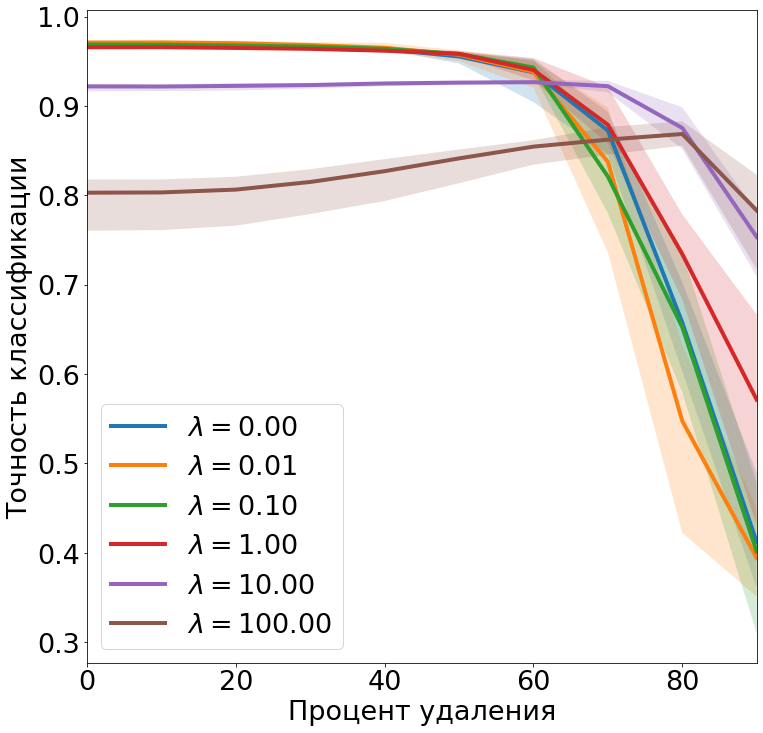

In [13]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_var')
#plt.show()


In [9]:
utils.test_acc_hyper(hnet, device, test_loader, lambda_encode, lamb)

{tensor(0.0010): 0.1014,
 tensor(0.0100): 0.9693,
 tensor(0.1000): 0.9679,
 tensor(1): 0.9668,
 tensor(10): 0.9211,
 tensor(100.): 0.7336}